In [1]:
import os
import sys

prev_dir = os.path.dirname(os.getcwd())
if prev_dir not in sys.path: sys.path.append(prev_dir)

import math
import traceback
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import warnings

import const
from data_gen.density import ExpGLMDensity, NonLDSDensity
from data_gen.phi_embedding import LDSPhiEmbedding, PhiEmbedding
from estimation.score_matching import ScoreMatching
import numpy as np
import matplotlib.axes as axes
import matplotlib.pyplot as plt
import torch
import scipy.stats as stats
import scipy
import utils

In [2]:
T = Union[np.ndarray, torch.Tensor]
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

## Cartpole stop condition and step functions

In [3]:
# Define synthetic env as a step function

# Cartpole constants
CP_FORCE_MAG = 10.0
CP_GRAVITY = 9.8
CP_MASSCART = 1.0
CP_MASSPOLE = 0.1
CP_TOTAL_MASS = CP_MASSCART + CP_MASSPOLE
CP_LENGTH = 0.5
CP_POLEMASS_LENGTH = CP_MASSPOLE * CP_LENGTH
CP_TAU = 0.02
CP_X_THRESHOLD = 2.4
CP_THETA_THRESHOLD_RADIANS = 12 * 2 * math.pi / 360


def is_cartpole_done(state: Union[np.ndarray, Tuple, List]) -> bool:
    """
    Returns True if cartpole is in done state.
    """
    x, theta = state[0], state[2]
    return bool(
        x < -CP_X_THRESHOLD
        or x > CP_X_THRESHOLD
        or theta < -CP_THETA_THRESHOLD_RADIANS
        or theta > CP_THETA_THRESHOLD_RADIANS
    )


# Cartpole step function
def step_cartpole(
    action_query: Union[float, int],
    state_query: np.ndarray,
    **kwargs,
) -> Tuple[np.ndarray, float, bool, Dict]:
    """
    Standard step function for cartpole.

    Args:
        action_query: Action in {-1, +1}.
        state_query: 4-tuple state for cartpole

    Returns:
        (next_state, reward, done, info):
            4-tuple next state, reward from the step, done flag for stopping,
            extra info (e.g. "actual_next_state").
    """
    x, x_dot, theta, theta_dot = state_query.tolist()
    force = float(action_query * CP_FORCE_MAG)

    costheta = math.cos(theta)
    sintheta = math.sin(theta)

    # For the interested reader:
    # https://coneural.org/florian/papers/05_cart_pole.pdf
    temp = (
        force + CP_POLEMASS_LENGTH * theta_dot**2 * sintheta
    ) / CP_TOTAL_MASS
    thetaacc = (CP_GRAVITY * sintheta - costheta * temp) / (
        CP_LENGTH * (4.0 / 3.0 - CP_MASSPOLE * costheta**2 / CP_TOTAL_MASS)
    )
    xacc = temp - CP_POLEMASS_LENGTH * thetaacc * costheta / CP_TOTAL_MASS

    x = x + CP_TAU * x_dot
    x_dot = x_dot + CP_TAU * xacc
    theta = theta + CP_TAU * theta_dot
    theta_dot = theta_dot + CP_TAU * thetaacc

    next_state: Tuple = (x, x_dot, theta, theta_dot)
    done = is_cartpole_done(next_state)
    reward = float(not done)

    return np.array(next_state, dtype=np.float32), reward, done, {}


CP_NOISE_STDEV_THRESHOLD = np.array([
    CP_X_THRESHOLD,
    (CP_TAU * CP_FORCE_MAG / CP_TOTAL_MASS),
    CP_THETA_THRESHOLD_RADIANS,
    (CP_TAU * CP_GRAVITY / CP_LENGTH)
])


def step_cartpole__noise_after__gaussian(
    action_query: Union[float, int],
    state_query: np.ndarray,
    noise_sigma: np.ndarray = (1e-1 * CP_NOISE_STDEV_THRESHOLD)**2,
    noise_sampling_method: str = 'inv_cdf',
    noise_sampling_kwargs: Dict[str, Any] = {
        'inv_cdf_linspace_L': 1000,
        'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
        'inv_cdf_round_decimals': 2
    },
    **kwargs,
) -> Tuple[np.ndarray, float, bool, Dict]:
    """
    next_state = cartpole(action_query, state_query) + eta, eta ~ Gaussian.
    
    Args:
        noise_sigma: Diag of covariance matrix of gaussian noise.
    """
    next_state = step_cartpole(action_query, state_query)[0]
    actual_next_state = next_state.copy()
    
    # Add noise
    d_s, d_a = 4, 1
    density = NonLDSDensity(d_s, sigma=noise_sigma)
    W = np.zeros((d_s, d_s+d_a))  # phi = [s, a]
    phi_embedding = LDSPhiEmbedding(d_s, d_a)
    s = state_query[None, :]  # shape (1, d_s)
    a = np.array(action_query).reshape((1, 1))  # shape (1, d_a)
    eta, phi = density.sample_iid(
        W, s, a, phi_embedding, 1,
        sampling_method=noise_sampling_method,
        sampling_kwargs=noise_sampling_kwargs,
    )  # shape (1, 1, d_s), (1, d_phi)
    next_state += eta.numpy()[0, 0]
    
    done = is_cartpole_done(next_state)
    reward = float(not done)
    
    return next_state, reward, done, {"actual_next_state": actual_next_state}


def step_cartpole_custom(
    action_query: Union[float, int],
    state_query: np.ndarray,
    **kwargs,
) -> Tuple[np.ndarray, float, bool, Dict]:
    """
    next_state = cartpole(action_query, state_query) + eta, eta ~ Exp (only on x coord).
    """
    next_state = step_cartpole(action_query, state_query)[0]
    actual_next_state = next_state.copy()

    # Add noise
    next_state += np.random.randn(4) * (1e-2 * CP_NOISE_STDEV_THRESHOLD)

    done = is_cartpole_done(next_state)
    reward = float(not done)

    return next_state, reward, done, {"actual_next_state": actual_next_state}


# Define a custom step function and custom density

## Use the definitions in the simulation code below

## "Add state and action" step function

$s' = (s + a) + \eta_t$ where $\eta_t \sim \mathcal{N}(0, \sigma^2)$

In [4]:
#### ADD STATE and ACTION FUNCTION
#### ==>> gaussian can estimate this
ADD_SA__THRESHOLD = np.array([10.])
ADD_SA__NOISE_STDEV_THRESHOLD = np.array([1.])

def is__add_sa__done(state: np.ndarray) -> bool:
    return (
            state > ADD_SA__THRESHOLD
            or state < -ADD_SA__THRESHOLD
    )


def step__add_sa(
    action_query: Union[float, int],
    state_query: np.ndarray,
    **kwargs,
) -> Tuple[np.ndarray, float, bool, Dict]:
    """
    s' = s + a
    """
    next_state = state_query + action_query
    done = is__add_sa__done(next_state)
    reward = float(not done)
    return next_state, reward, done, {}


def step__add_sa__noisy(
    action_query: Union[float, int],
    state_query: np.ndarray,
    **kwargs,
) -> Tuple[np.ndarray, float, bool, Dict]:
    """
    s' = f_synth (s, a) + eps
    """
    next_state = step__add_sa(action_query, state_query)[0]
    actual_next_state = next_state.copy()

    # Add noise
    next_state += np.random.randn(1) * (1e-1 * ADD_SA__NOISE_STDEV_THRESHOLD)

    done = is__add_sa__done(next_state)
    reward = float(not done)

    return next_state, reward, done, {"actual_next_state": actual_next_state}


# Things that I have tried that seem to affect the density fit:
# 1) Setting ALPHA.
# 2) Increasing "sharpness" of the base function, i.e.
# logq = - x.norm(p=ALPHA, dim=-1).pow(ALPHA) / ALPHA / CONSTANT for some CONSTANT. Smaller CONST = sharper.
# 3) Different psi mappings.

class CustomDensity(ExpGLMDensity):
    ALPHA = 2.
    SUPPORT_LO = -np.inf
    SUPPORT_HI = np.inf
    IS_PRODUCT_DENSITY = True

    def __init__(self, d_s: int):
        super(CustomDensity, self).__init__(d_s)
        self.d_psi = self.d_s * 1 # adding extra coordinates

    def __repr__(self) -> str:
        ALPHA = CustomDensity.ALPHA
        return f"$\\exp ( - \\frac{{ ||s'||_\\alpha^\\alpha }}{{ \\alpha }} ) \\cdot \\exp ( \\langle sin^2(s'), W \\phi(s, a) \\rangle - Z_{{s,a}}(W) )$\n$\\alpha={ALPHA:.1f}$"

    def in_support(self, x: T) -> torch.Tensor:
        return torch.all(
            torch.logical_and(x >= self.SUPPORT_LO, x <= self.SUPPORT_HI), dim=1
        )

    def psi(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        psi = torch.concat([x], dim=-1)
        return psi

    def logq(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        ALPHA = self.ALPHA
        logq = - x.norm(p=ALPHA, dim=-1).pow(ALPHA) / ALPHA / (1e-2 * ADD_SA__NOISE_STDEV_THRESHOLD[0]) ** 2 # shape (n)
        return logq


## "sin" step function

$s' \sim \mathrm{Pr}_{W} (\cdot | s, a)$ where the $\psi$ function of $\mathrm{Pr}_{W} (\cdot | s, a)$ is a $\sin(\cdot)$ and we know Score Matching can recover the parameter $\theta$ of $\mathrm{Pr}_{W} (\cdot | \theta)$.

In [5]:
class CustomSinDensity(ExpGLMDensity):
    ALPHA = 1.7
    SUPPORT_LO = -10.
    SUPPORT_HI = 10.
    P = 4
    IS_PRODUCT_DENSITY = True

    def __init__(self, d_s: int):
        super(CustomSinDensity, self).__init__(
            d_s,
            use_scipy_integrate=False,
            integrate_lo=self.SUPPORT_LO,
            integrate_hi=self.SUPPORT_HI,
        )
        self.d_psi = self.d_s

    def __repr__(self) -> str:
        ALPHA = self.ALPHA
        P = self.P
        return f"$\\exp ( - \\frac{{ ||s'||_\\alpha^\\alpha }}{{ \\alpha }} ) \\cdot \\exp ( \\langle sin({P}s'), W \\phi(s, a) \\rangle - Z_{{s,a}}(W) )$\n$\\alpha={ALPHA:.1f}$"

    def in_support(self, x: T) -> torch.Tensor:
        return torch.all(
            torch.logical_and(x >= self.SUPPORT_LO, x <= self.SUPPORT_HI), dim=1
        )

    def psi(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        P = self.P
        psi = torch.sin(P*x)
        return psi

    def plot_psi(self):
        x = np.linspace(-5,5).reshape(50,1)
        plt.plot(x, self.psi(x))
        plt.show()

    def logq(self, x: T) -> torch.Tensor:
        x = utils.to_torch(x) # shape (n, d_s)
        ALPHA = self.ALPHA
        logq = - 1. * (x.norm(p=ALPHA, dim=-1).pow(ALPHA) / ALPHA) # shape (n)
        return logq


#### Using CustomSinDensity for step function
#### ==>> gaussian cannot estimate this
CUSTOM_SIN__THRESHOLD = np.array([2.])
custom_sin_density = CustomSinDensity(d_s=1)
custom_sin_phi_embedding = LDSPhiEmbedding(d_s=1, d_a=1)
CUSTOM_SIN__W0 = torch.tensor([[1., 1.]])


def is__custom_sin__done(state: np.ndarray) -> bool:
    return (
            state > CUSTOM_SIN__THRESHOLD
            or state < -CUSTOM_SIN__THRESHOLD
    )


def step__custom_sin(
    action_query: Union[float, int],
    state_query: np.ndarray,
    custom_sin_density_sampling_kwargs: Dict[str, Any] = {
        'inv_cdf_linspace_L': 1000,
        'inv_cdf_dicts': ({}, {}, {}), # Init integ_vals_dict, cdf_supp_dict, cdf_dict
        'inv_cdf_round_decimals': 2
    },
    **kwargs,
) -> Tuple[np.ndarray, float, bool, Dict]:
    """
    s' ~ Pr_W ( \cdot | s, a)
    """
    s = state_query[None, :]  # shape (1, d_s)
    a = np.array(action_query).reshape((1, 1))  # shape (1, d_a)
    next_state, phi = custom_sin_density.sample_iid(
        CUSTOM_SIN__W0, s, a, custom_sin_phi_embedding, 1,
        sampling_method="inv_cdf",
        sampling_kwargs=custom_sin_density_sampling_kwargs,
    )  # shape (1, 1, d_s), (1, d_phi)
    next_state = next_state.numpy()[0, 0]
    actual_next_state = next_state.copy()

    done = is__custom_sin__done(next_state)
    reward = float(not done)

    return next_state, reward, done, {"actual_next_state": actual_next_state}


## Simulation

1. Sample iid from from synthetic MDP
2. Fit W_LS and score matching
3. Plot densities for fixed s, a


## How to simulate:

- Change `step_cartpole*()` function in generating new states and plotting cells.
- Change the Score Matching density.

In [6]:
#### cartpole
# state_ranges = torch.tensor([CP_X_THRESHOLD, 0.2, CP_THETA_THRESHOLD_RADIANS, 0.2])
# d_s = 4
#### add_sa
# state_ranges = torch.tensor([5.])
# d_s = 1
#### custom_sin
state_ranges = torch.tensor([1.])
d_s = 1
d_a = 1

# Get next states
num_samples = 1000
phis = torch.empty((num_samples, d_s+d_a))
next_states = torch.empty((num_samples, d_s))
rewards = np.empty(num_samples)
for i in range(num_samples):
    state_query = ((2 * torch.rand(d_s) - 1) * state_ranges)
    action_query = (2 * torch.randint(0,2,(d_a,)) - 1).item()
    phis[i,:d_s] = state_query
    phis[i, d_s] = action_query

    next_state, reward, done, _ = step__custom_sin(
        action_query=action_query, state_query=state_query.numpy()
    )
    next_states[i, :] = torch.tensor(next_state)
    rewards[i] = reward

print(f"Counts of rewards in {num_samples} samples:")
print(np.unique(rewards, return_counts=True))

Counts of rewards in 1000 samples:
(array([0., 1.]), array([ 61, 939]))


In [7]:
# Fit density using W_LS
sigma = None
SM_lam = 0.

# fit density with normal distribution.
norm_density = NonLDSDensity(d_s, sigma)
LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
sm_estimator = ScoreMatching(norm_density)
ns = np.logspace(np.log10(num_samples)/2, np.log10(num_samples), 10, dtype=int)
train_losses = []
for i in ns:
    W_LS = sm_estimator.W_estimate(
        next_states[:i, :], phis[:i, :], lam=SM_lam, return_Vb_estimates=False
    )
    train_losses.append(torch.norm(next_states - phis @ W_LS.T, 'fro').item()/i)
# print("train_losses of W_LS vs num_samples:", train_losses)


# Fit density using score matching
#### cartpole
# norm_density2 = CustomDensity(d_s = 1)
#### add_sa
# norm_density2 = NonLDSDensity(d_s=1, sigma=(1e-1 * ADD_SA__NOISE_STDEV_THRESHOLD)**2)
#### custom_sin
norm_density2 = CustomSinDensity(d_s=1)
LDS_phi_embedding = LDSPhiEmbedding(d_s, d_a)
sm_estimator2 = ScoreMatching(norm_density2)
SM_lam = 0.
# just estimate the next state x value
next_state_x = next_states[:, 0][:, None]  # shape (num_samples, 1)
W_SM = sm_estimator2.W_estimate(next_state_x, phis, lam=SM_lam, return_Vb_estimates=False)

print("W_LS:", W_LS)
print("W_SM:", W_SM)
print("normalization const:", W_LS[0, 0] / W_SM[0, 0])
print(W_SM * (W_LS[0,0]/W_SM[0,0])) # RENORMALIZED TO CHECK FOR NORMAL DISTRIBUTION

W_LS: tensor([[ 0.0186, -0.0206]], grad_fn=<ReshapeAliasBackward0>)
W_SM: tensor([[1.0312, 1.0058]], grad_fn=<ReshapeAliasBackward0>)
normalization const: tensor(0.0180, grad_fn=<DivBackward0>)
tensor([[0.0186, 0.0181]], grad_fn=<MulBackward0>)


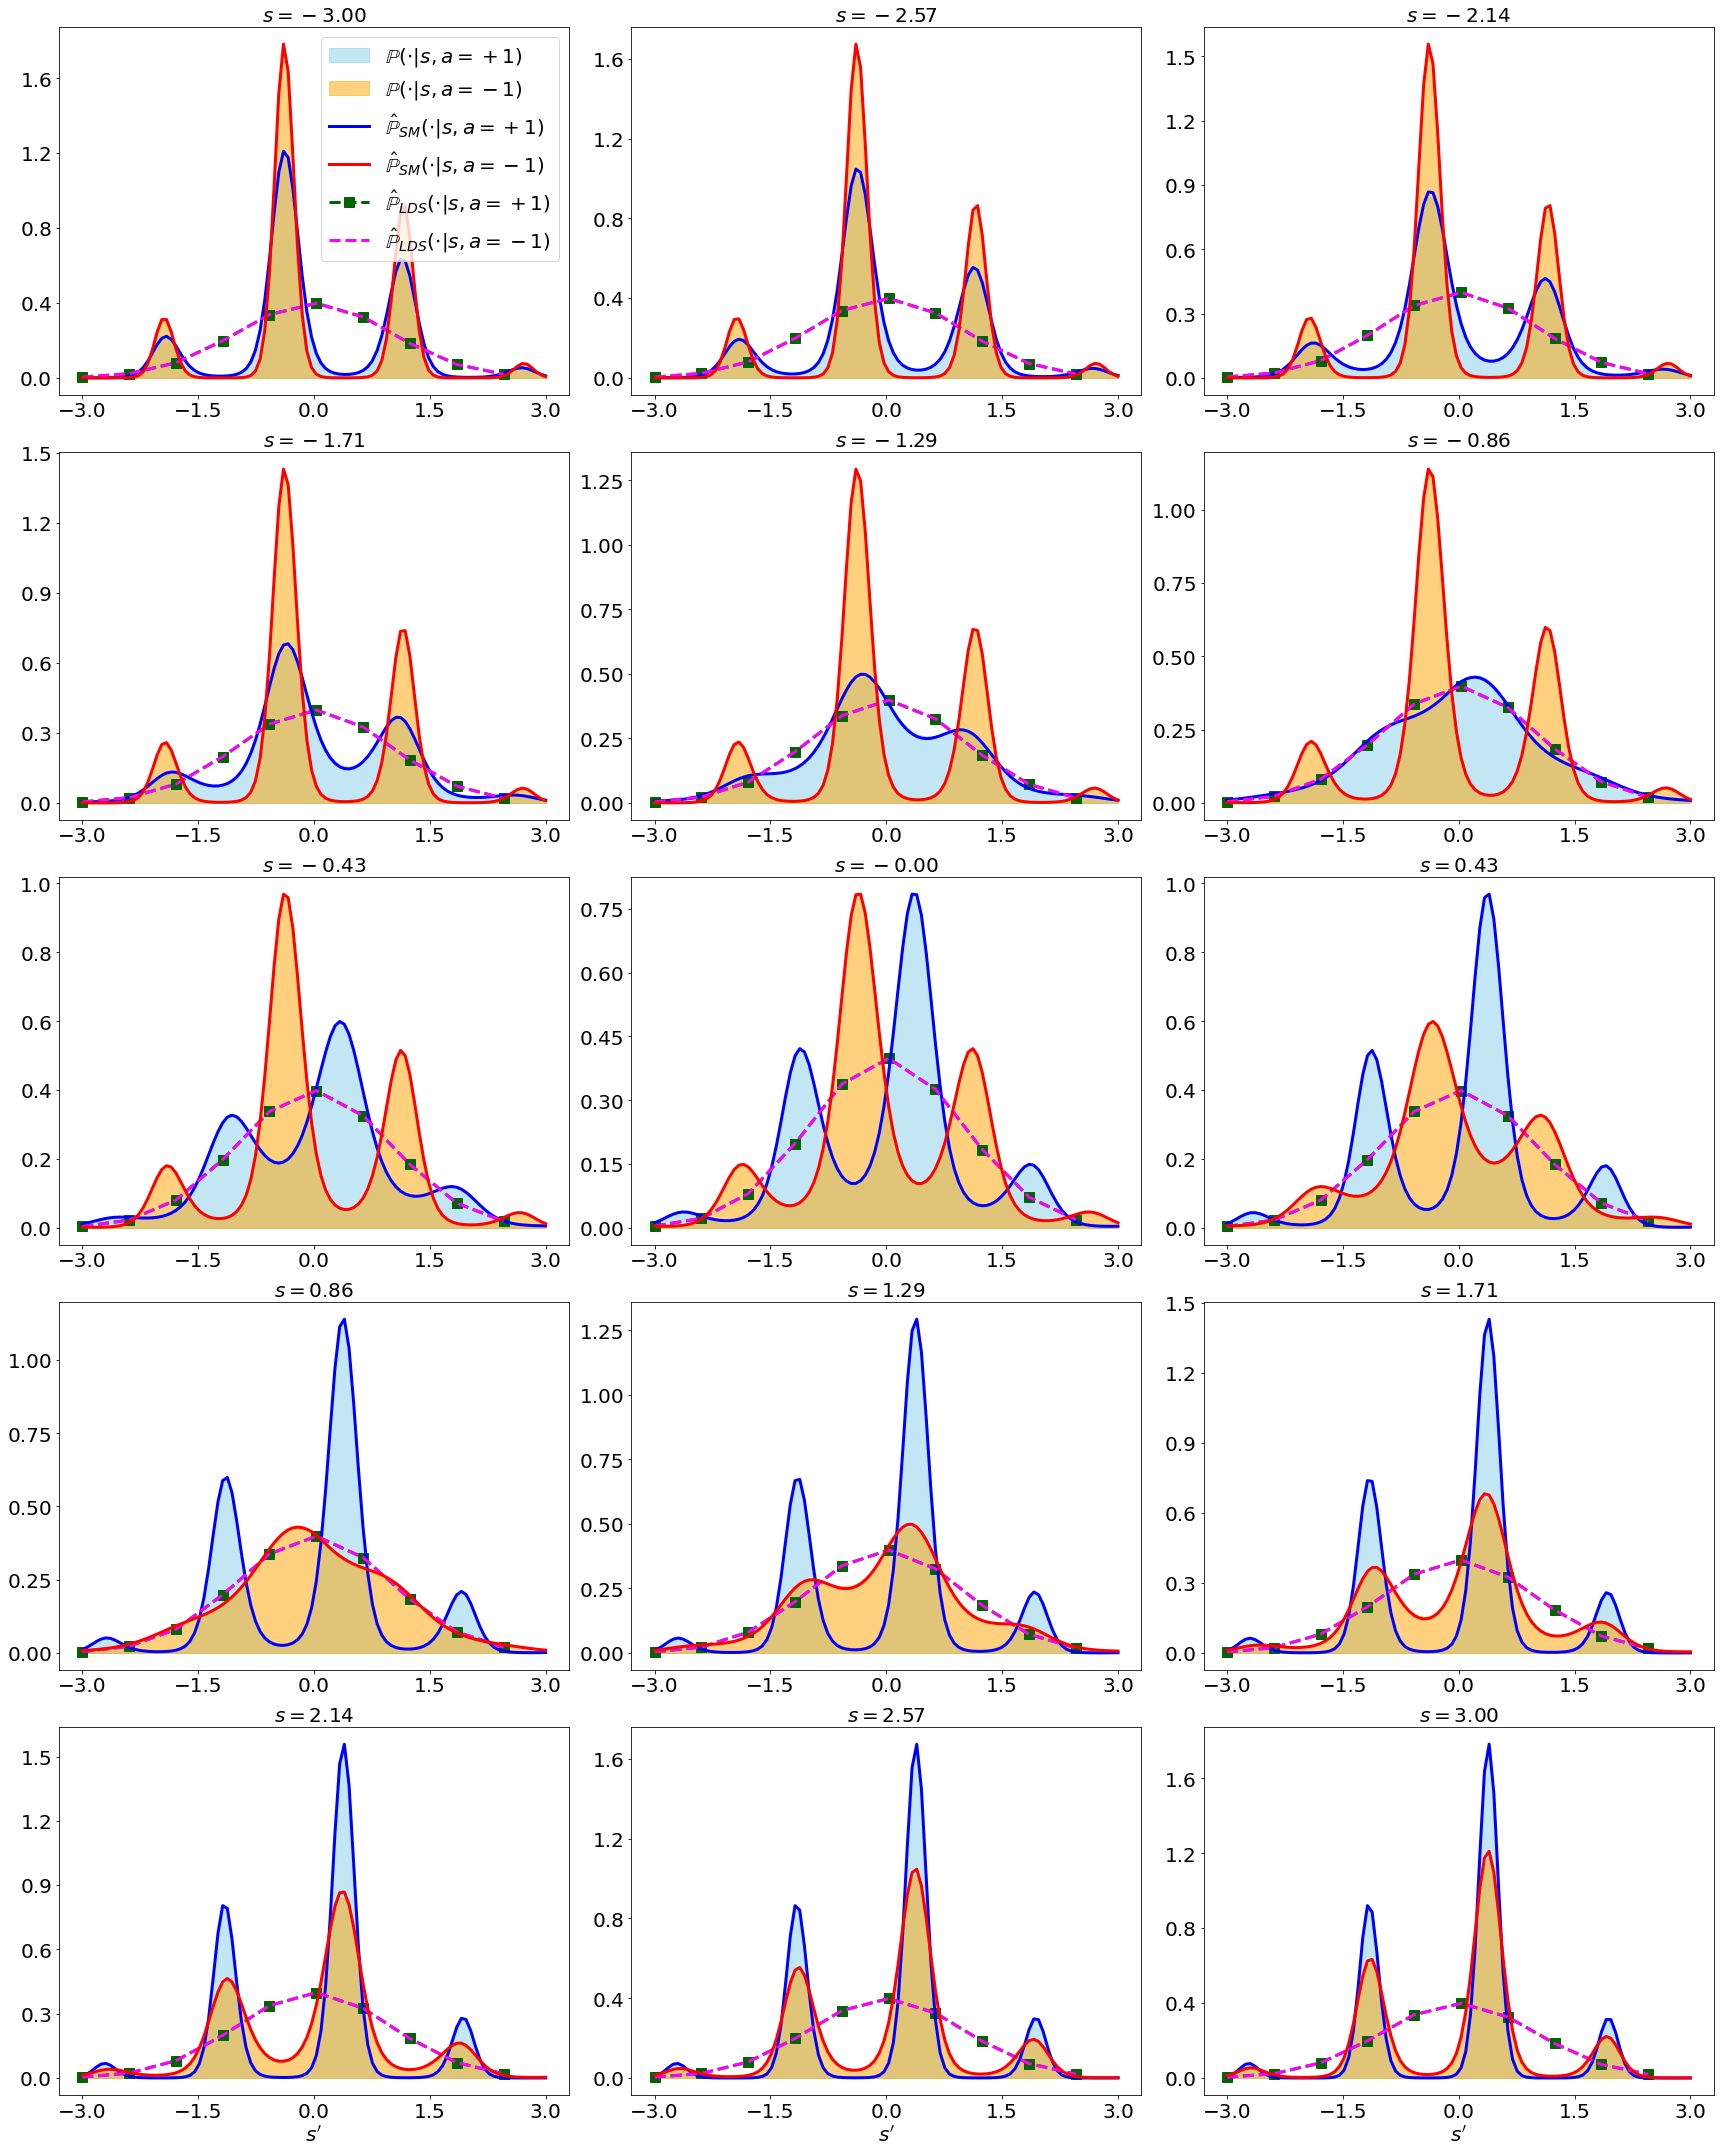

In [8]:
# Plot the density of each state var separately
fontsize = 20

nc = 3
nr = 5
s_tests = torch.linspace(-3., 3., nc*nr)[:, None]
fig, axs = plt.subplots(nr, nc, figsize=(nc*8, nr*6))

test_W = -torch.rand_like(W_SM)
for i in range(nr):
    for j in range(nc):
        # Define query state, action
        phi_test = torch.empty(d_s+d_a)
        s_test = s_tests[i*nc+j]
        # a_test = (2 * torch.randint(0,2,(d_a,)) - 1).item()
        for a_test in (1, -1):
            phi_test[0:d_s] = s_test
            phi_test[d_s] = a_test

            # Plot a shaded region of true density
            mean = 0.
            #### add_sa
            # xs = np.linspace(
            #     mean - 3 * 1e-1 * ADD_SA__NOISE_STDEV_THRESHOLD[0],
            #     mean + 3 * 1e-1 * ADD_SA__NOISE_STDEV_THRESHOLD[0]
            # )
            #### custom_sin
            xs = np.linspace(mean - 3*1., mean + 3*1., 100)

            prob = norm_density2.density(
                utils.to_torch(xs)[:, None], CUSTOM_SIN__W0, phi_test[None, :]
            ).detach().numpy()[:, 0]
            axs[i, j].fill_between(
                xs, prob, where=(xs > -np.inf),
                label=f"$\\mathbb{{P}}( \\cdot | s, a={a_test:+})$",
                alpha=0.5,
                color="skyblue" if a_test > 0. else "orange",
            )

            axs[i, j].set_title(f'$s = {s_test.numpy()[0]:.2f}$',
                                fontsize=fontsize)

            # normal is plotted
            #### add_sa
            # axs[i,j].plot(xs, stats.norm.pdf(xs, mean, 1e-1 * ADD_SA__NOISE_STDEV_THRESHOLD), label="W_LS")
            #### custom_sin
            axs[i,j].plot(
                xs[::10], stats.norm.pdf(xs, mean, 1.)[::10],
                ("s--" if a_test > 0. else "--"),
                label=f"$\\hat{{\\mathbb{{P}}}}_{{LDS}} ( \\cdot | s, "
                      f"a={a_test:+})$",
                linewidth=3,
                color="darkgreen" if a_test > 0. else "magenta",
                markersize=10,
            )

            # custom is plotted
            axs[i,j].plot(
                xs,
                norm_density2.density(
                    utils.to_torch(xs)[:, None], W_SM, phi_test[None, :]
                ).detach().numpy(),
                linestyle="-",
                label=f"$\\hat{{\\mathbb{{P}}}}_{{SM}} ( \\cdot | s, a = "
                      f"{a_test:+})$",
                color="b" if a_test > 0. else "r",
                linewidth=3,
            )
            if i == (nr-1):
                axs[i, j].set_xlabel("$s'$", fontsize=fontsize)

        axs[i, j].xaxis.set_major_locator(plt.MaxNLocator(6))
        axs[i, j].yaxis.set_major_locator(plt.MaxNLocator(6))
        axs[i, j].tick_params(axis="x", labelsize=fontsize)
        axs[i, j].tick_params(axis="y", labelsize=fontsize)

handles, labels = plt.gca().get_legend_handles_labels()
order = [4, 5, 1, 3, 0, 2]
axs[0, 0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 fontsize=fontsize)

plt.tight_layout()
plt.savefig("plots/custom_sin__densities_sm_lds.png")
plt.savefig("plots/custom_sin__densities_sm_lds.pdf")
plt.show()


s = [0.5]


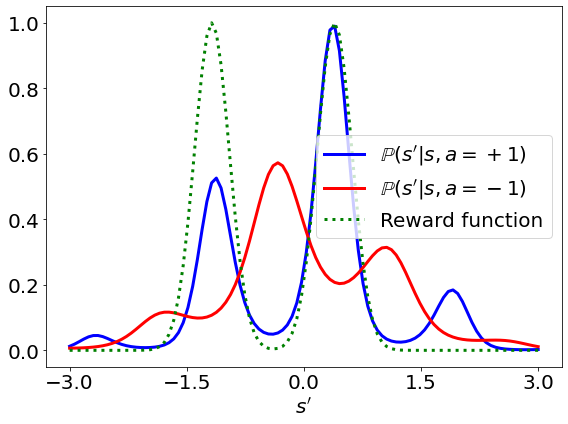

s = [0.5]


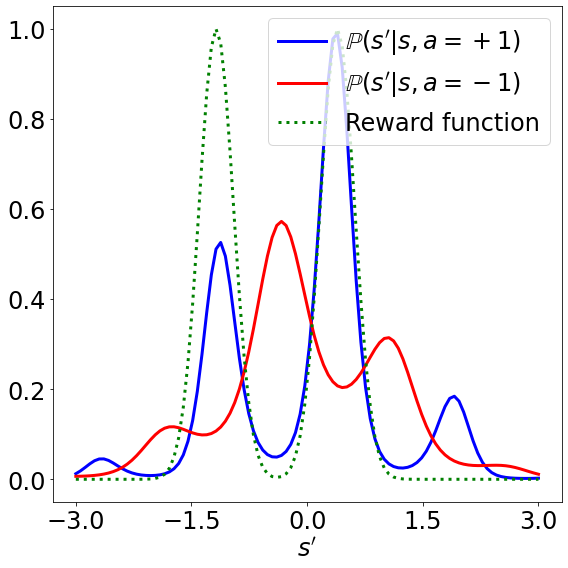

In [9]:
fontsize=20
import itertools

# Plot the density of each state var separately
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

# Define query state, action
phi_test = torch.empty(d_s+d_a)
s_test = torch.tensor([0.5])
print(f"s = {s_test.numpy()}")
colors = itertools.cycle("brg")
for a_test in (1, -1):
    phi_test[0:d_s] = s_test
    phi_test[d_s] = a_test

    mean = 0.
    xs = np.linspace(mean - 3*1., mean + 3*1., 100)
    xs_torch = utils.to_torch(xs)
    prob = norm_density2.density(
        xs_torch[:, None], CUSTOM_SIN__W0, phi_test[None, :]
    ).detach().numpy()

    # custom is plotted
    axs.plot(
        xs, prob, label=f"$\\mathbb{{P}} (s' | s, a={a_test:+})$",
        color=next(colors), linewidth=3,
    )
P = norm_density2.P
rewards = np.exp(-10*(xs - np.pi/(2*P))**2) + \
          np.exp(-10*(xs + 3*np.pi/(2*P))**2)
axs.plot(xs, rewards, label=f"Reward function",
         color=next(colors), linestyle=":", linewidth=3)
axs.set_xlabel("$s'$", fontsize=fontsize)

plt.legend(fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
axs.xaxis.set_major_locator(plt.MaxNLocator(6))
axs.yaxis.set_major_locator(plt.MaxNLocator(6))

plt.tight_layout()
plt.savefig("plots/custom_sin__transitions_rewards.png")
plt.savefig("plots/custom_sin__transitions_rewards.pdf")
plt.show()


#### for poster
fontsize=24
import itertools

# Plot the density of each state var separately
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# Define query state, action
phi_test = torch.empty(d_s+d_a)
s_test = torch.tensor([0.5])
print(f"s = {s_test.numpy()}")
colors = itertools.cycle("brg")
for a_test in (1, -1):
    phi_test[0:d_s] = s_test
    phi_test[d_s] = a_test

    mean = 0.
    xs = np.linspace(mean - 3*1., mean + 3*1., 100)
    xs_torch = utils.to_torch(xs)
    prob = norm_density2.density(
        xs_torch[:, None], CUSTOM_SIN__W0, phi_test[None, :]
    ).detach().numpy()

    # custom is plotted
    axs.plot(
        xs, prob, label=f"$\\mathbb{{P}} (s' | s, a={a_test:+})$",
        color=next(colors), linewidth=3,
    )
P = norm_density2.P
rewards = np.exp(-10*(xs - np.pi/(2*P))**2) + \
          np.exp(-10*(xs + 3*np.pi/(2*P))**2)
axs.plot(xs, rewards, label=f"Reward function",
         color=next(colors), linestyle=":", linewidth=3)
axs.set_xlabel("$s'$", fontsize=fontsize)

plt.legend(fontsize=fontsize)

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
axs.xaxis.set_major_locator(plt.MaxNLocator(6))
axs.yaxis.set_major_locator(plt.MaxNLocator(6))

plt.tight_layout()
plt.savefig("plots/poster__custom_sin__transitions_rewards.png")
plt.savefig("plots/poster__custom_sin__transitions_rewards.pdf")
plt.show()

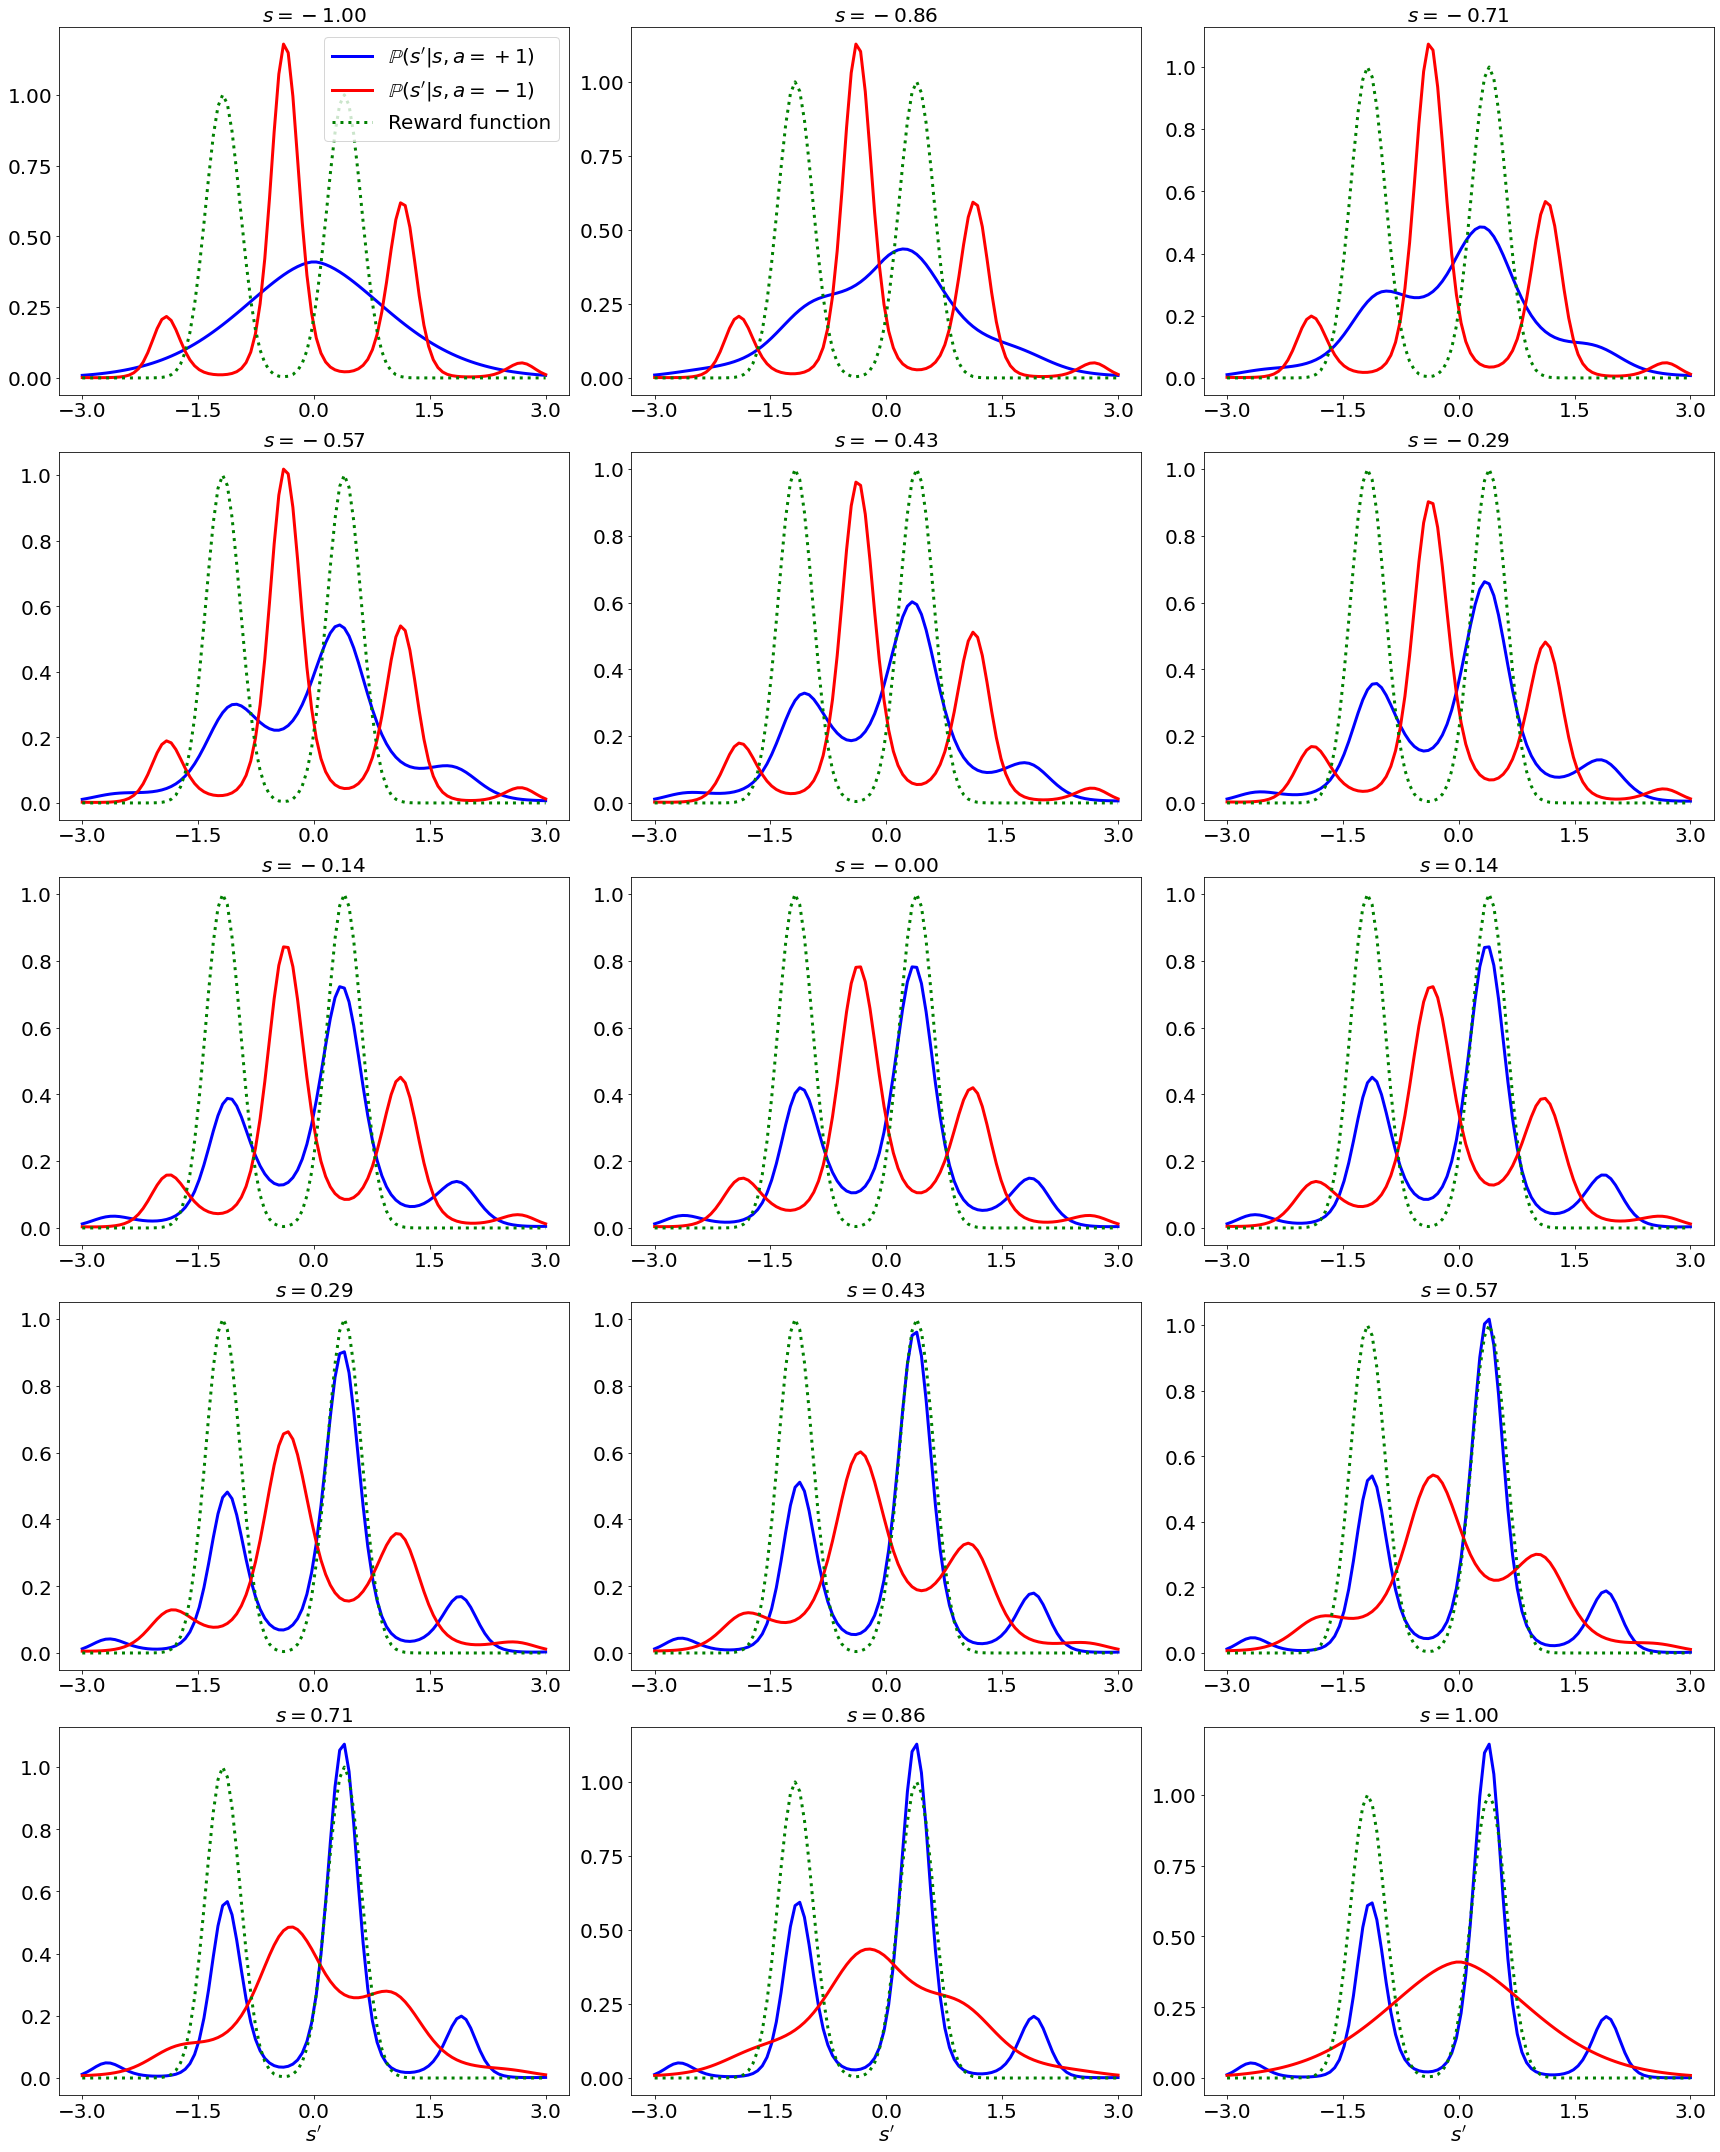

In [10]:
fontsize = 20

nc = 3
nr = 5
s_tests = torch.linspace(-state_ranges.item(), state_ranges.item(), nc*nr)[:, None]
fig, axs = plt.subplots(nr, nc, figsize=(nc*8, nr*6))

test_W = -torch.rand_like(W_SM)
for i in range(nr):
    for j in range(nc):
        # Define query state, action
        phi_test = torch.empty(d_s+d_a)
        s_test = s_tests[i*nc+j]
        for a_test in (1, -1):
            phi_test[0:d_s] = s_test
            phi_test[d_s] = a_test
            # print(f"state {s_test}, action {a_test}")

            axs[i, j].set_title(f'$s = {s_test.numpy()[0]:.2f}$',
                                fontsize=fontsize)

            mean = 0.
            xs = np.linspace(mean - 3*1., mean + 3*1., 100)
            xs_torch = utils.to_torch(xs)
            prob = norm_density2.density(
                xs_torch[:, None], CUSTOM_SIN__W0, phi_test[None, :]
            ).detach().numpy()

            # custom is plotted
            axs[i, j].plot(
                xs, prob, label=f"$\\mathbb{{P}} ( s' | s, a={a_test:+})$",
                color="b" if a_test > 0. else "r",
                linewidth=3,
            )
            if i == (nr-1):
                axs[i, j].set_xlabel("$s'$", fontsize=fontsize)
        P = norm_density2.P
        rewards = np.exp(-10*(xs - np.pi/(2*P))**2) + \
                  np.exp(-10*(xs + 3*np.pi/(2*P))**2)
        axs[i,j].plot(xs, rewards, label=f"Reward function", linestyle=":",
                      linewidth=3, color="g")
        axs[i, j].xaxis.set_major_locator(plt.MaxNLocator(6))
        axs[i, j].yaxis.set_major_locator(plt.MaxNLocator(6))
        axs[i, j].tick_params(axis="x", labelsize=fontsize)
        axs[i, j].tick_params(axis="y", labelsize=fontsize)

axs[0, 0].legend(fontsize=fontsize)

plt.tight_layout()
plt.savefig("plots/custom_sin__transitions_rewards_grid.png")
plt.savefig("plots/custom_sin__transitions_rewards_grid.pdf")
plt.show()
